In [36]:
# install libraries
!pip install yfinance matplotlib pandas


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [37]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

[*********************100%***********************]  1 of 1 completed


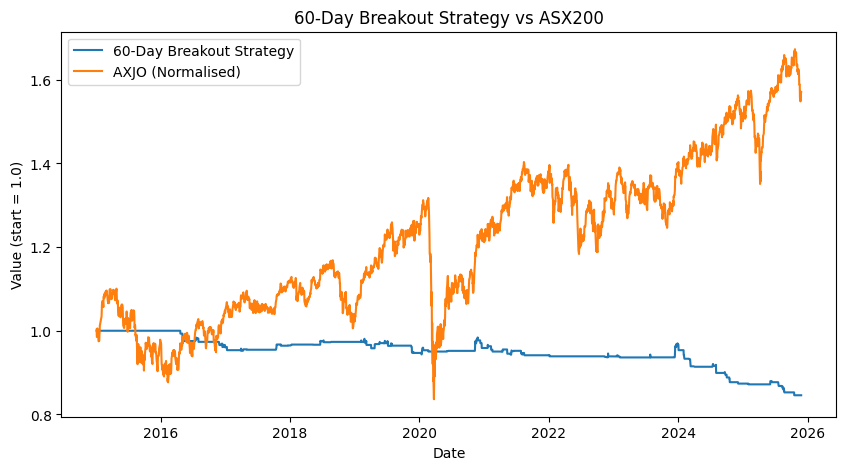

In [41]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# download ASX200 data since 2015
ticker = '^AXJO'
start_date = '2015-01-01'
data = yf.download(ticker, start=start_date)

# define 60-day Donchian Channel (using prior data only)
lookback = 60
data['high_n'] = data['High'].rolling(lookback).max().shift(1)   # highest high of prior 60 days
data['low_n']  = data['Low'].rolling(lookback).min().shift(1)    # lowest low of prior 60 days

# generate breakout signals (ensure 1D Series for proper comparisons)
close  = data['Close'].squeeze()
high_n = data['high_n'].squeeze()

data['long_signal'] = close > high_n    # upside breakout only (long only)

# create positions: 0 = no position, 1 = long
data['position'] = 0
data.loc[data['long_signal'], 'position'] = 1

# compute daily AXJO returns
data['returns'] = data['Close'].pct_change()

# strategy returns using yesterday's position (prevents look-ahead bias)
data['strategy_returns'] = data['position'].shift(1) * data['returns']

# build equity curve
data['equity_curve'] = (1 + data['strategy_returns']).cumprod()

# normalise AXJO to start at 1 for comparison
data['axjo_normalised'] = data['Close'] / data['Close'].iloc[0]

# remove rows with NaNs caused by rolling/shift
plot_data = data[['equity_curve', 'axjo_normalised']].dropna()

# plot both curves
plt.figure(figsize=(10, 5))
plt.plot(plot_data.index, plot_data['equity_curve'], label='60-Day Breakout Strategy')
plt.plot(plot_data.index, plot_data['axjo_normalised'], label='AXJO (Normalised)')
plt.title("60-Day Breakout Strategy vs ASX200")
plt.xlabel("Date")
plt.ylabel("Value (start = 1.0)")
plt.legend()
plt.show()
